In [27]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy
from sympy import symbols, pprint
import csv
import scipy.optimize as opt
from math import log10, floor

In [28]:
# Settings + Notes
"""The units used are in SI units."""

# Plotting Settings
plt.style.use("default")

# # remove interactive mode
# plt.ioff()

# # disable images from automatically showing up
# use("Agg")

# Exporting Saved Images
def export_plot(plot, filename, savelocation="../exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

# Export to CSV
def export_plotting_data(dataArray, pre="", path="../exports/plottingData.csv", reset=False, newSet=False):
    if reset:
        open(path, "w").close()
    file = open(path, "a")
    if newSet:
        file.write("\n")
    file.write(pre)
    wr = csv.writer(file, quoting=csv.QUOTE_ALL)
    wr.writerow(dataArray)
    file.close()

In [29]:
# Constants
G = ufloat(9.81, 0.03)  # the gravitational acceleration measured at UofT MP: https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Introduction.html

UNCERTAINTY_RULER = 0.005  # meters
UNCERTAINTY_IPHONE = 0.1  # seconds 

LENGTH_SLINKY = ufloat(1.8, UNCERTAINTY_RULER)  # meters

In [30]:
# Equations
def equation_10(w_n):
    return umath.pow((umath.pow(W0, 2) + umath.pow(w_n, 2)), 1/2)

def mean(array):
    return sum(array)/len(array)

def standard_deviation(array):
    numerator = 0
    arrayMean = mean(array)
    N = len(array)
    for i in range(N):
        numerator += umath.pow((array[i] - arrayMean), 2)
    return umath.pow((numerator/N), 1/2)

def convert_to_ufloat(data, uncert):
    if not isinstance(data, (list, tuple, set)):
        return ufloat(data, uncert)
    return [ufloat(e, uncert) for e in data]

def seperate_ufloat(data):
    if not isinstance(data, (list, tuple, set)):
        return data.nominal_value, data.std_dev
    nominals, devs = [], []
    for e in data:
        nominals.append(e.nominal_value)
        devs.append(e.std_dev)
    return nominals, devs

def chiSquared(dataX, dataY, f):
    chi2 = 0
    for i in range(len(dataX)):
        collected = dataY[i]
        actual = f(dataX[i])
        chi2 = (umath.pow(actual - collected, 2))/actual
    return chi2

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def coeff_of_determination(dataX, dataY, func):
    N = len(dataX)
    yBar = mean(dataY)
    SS_tot = [umath.pow((e - yBar), 2) for e in dataY]
    SS_reg = [umath.pow((func(dataX[i]) - yBar), 2) for i in range(N)]
    SS_res = [umath.pow((dataY[i] - func(dataX[i])), 2) for i in range(N)]
    return 1 - sum(SS_res)/sum(SS_tot)

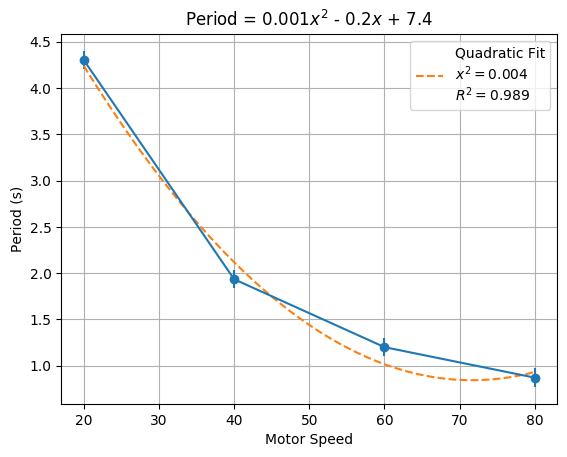

In [31]:
# Deriving a relationship between motor speed and period.
motorSpeed = [i for i in range(20, 100, 20)]
periods = [4.3, 5.8/3, 6.0/5, 8.7/10]
periods = convert_to_ufloat(periods, UNCERTAINTY_IPHONE)

periods_nominal, periods_uncert = seperate_ufloat(periods)

z = np.polyfit(motorSpeed, periods_nominal, deg=2)
# generate line of best fit
p = np.poly1d(z)
xp = np.linspace(min(motorSpeed), max(motorSpeed), 100)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Motor Speed")
ax.set_ylabel("Period (s)")
ax.grid(True)
ax.set_title("Period = {}$x^2$ - {}$x$ + {}".format(round_sig(z[0], 1), round(abs(z[1]), 1), round(z[2], 1)))
ax.errorbar(motorSpeed, periods_nominal, yerr=periods_uncert,fmt="-o")
ax.plot( xp, p(xp), "--")

_chiSquared = chiSquared(motorSpeed, periods_nominal, lambda x: p(x))
r2 = coeff_of_determination(motorSpeed, periods_nominal, lambda x: p(x))

# legend
ax.legend(
    ["Quadratic Fit\n$x^2={}$\n$R^2={}$".format(round_sig(_chiSquared, 1), round_sig(r2, 3))]
    )

# export
export_plot(fig, "motorspeed_period_relation")

fig.show()

In [32]:
# Question 1: Determining c_0

times = [2.2, 1.8, 2.4, 1.9, 1.9, 1.9]
# update times to include uncertainty
for _ in range(len(times)):
    times.append(ufloat(times.pop(0), UNCERTAINTY_IPHONE)) # seconds
# calculate standard deviation and mean of time
sdTimes = standard_deviation(times)
averageTime = sum(times)/len(times)
C0 = LENGTH_SLINKY/averageTime

# pick the greater uncertainty
C0_SD = max(sdTimes, C0.std_dev)
print("The standard deviation for time is {}".format(C0_SD))

# Display the uncertainty
C0 = ufloat(C0.nominal_value, C0_SD.nominal_value)
print("The c_0 value is {} [m/s]".format(C0))
print("Percentage uncertainty: {}".format(C0.std_dev/C0.nominal_value))

"""There is a key assumptions made in this analysis: 

The applied frequency w >> w_0, thus using equation (5) results in c = c_0"""

The standard deviation for time is 0.21+/-0.04
The c_0 value is 0.89+/-0.21 [m/s]
Percentage uncertainty: 0.23693177197444326


'There is a key assumptions made in this analysis: \n\nThe applied frequency w >> w_0, thus using equation (5) results in c = c_0'

In [33]:
# Q2: Determine w_0 for the suspended slinky
height = ufloat(0.87, UNCERTAINTY_RULER)
W0 = umath.pow(G/height, 1/2)
print("The frequency of the slinky-pendulum is {} [rad/s]".format(W0))
print("Percentage Uncertainty: {}".format(W0.std_dev/W0.nominal_value))
print("The periods of the slinky-pendulum is {} [s]".format(2*np.pi/W0))

"""Though we can get a more accurate uncertainty value by taking greater data points, the 3 percentage uncertainty is not unreasonable because of the lower human error involved relative to the calculation of c_0."""

The frequency of the slinky-pendulum is 3.358+/-0.011 [rad/s]
Percentage Uncertainty: 0.003255052311620279
The periods of the slinky-pendulum is 1.871+/-0.006 [s]


'Though we can get a more accurate uncertainty value by taking greater data points, the 3 percentage uncertainty is not unreasonable because of the lower human error involved relative to the calculation of c_0.'

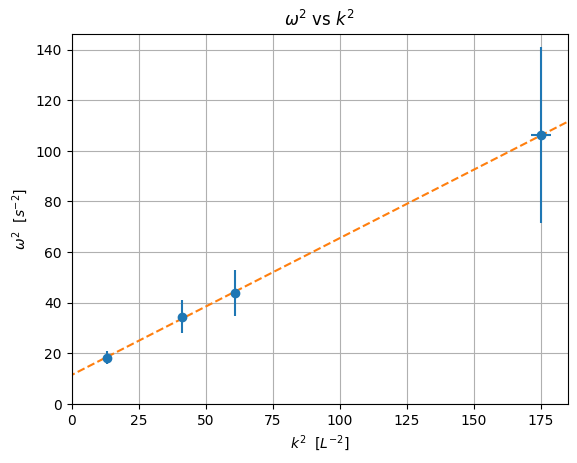

In [34]:
# Q3: Determine k values, plot w^2 vs k^2, deduce w_0^2 and c_0^2
# data
wavelengths = [80.5/100, (128-106)/100, (82-34.5)/100, (192.5 - 94.5)/100, (192.5 - 20)/100]  # meters
periods = [9.5/10, 7.7/10, 6.1/10, 10.7/10, 14.7/10]  # seconds
modes = [3, 3, 4, 2, 1]  # modes = n

# convert to ufloats
wavelengths = convert_to_ufloat(wavelengths, UNCERTAINTY_RULER)
periods = convert_to_ufloat(periods, UNCERTAINTY_IPHONE)

# calculate k^2 values, not do not use kn
K2 = []  # without n
for i in range(len(wavelengths)):
    value = umath.pow(2*np.pi/wavelengths[i], 2)
    K2.append(value)

# determine w^2 using period
W2 = []
for i in range(len(periods)):
    W2.append(umath.pow(2*np.pi/periods[i], 2))

# removed outliers
del W2[1]
del K2[1]

# seperate data and uncertainty
K2_nominal, K2_uncert = seperate_ufloat(K2)
W2_nominal, W2_uncert = seperate_ufloat(W2)

# plot w^2 against k^2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("$k^2$  $[L^{-2}]$")
ax.set_ylabel("$\omega^2$  $[s^{-2}]$")
ax.set_title("$\omega^2$ vs $k^2$")
ax.errorbar(K2_nominal, W2_nominal, W2_uncert, K2_uncert, fmt="o")

# fit the curve
z = np.polyfit(K2_nominal, W2_nominal, deg=1)
p = np.poly1d(z)
xMin = min(K2_nominal)
xMax = max(K2_nominal)
yMin = min(W2_nominal)
yMax = max(W2_nominal)
epsilon = 10
h = 50
xp = np.linspace(xMin - h, xMax + h)
ax.plot(xp, p(xp), "--")

# set limits
ax.set_xlim([0, xMax + epsilon])
ax.set_ylim([0, yMax + epsilon + 30])
# ax.annotate(s="Line of Best Fit", xy=(110,p(110)), xytext=(120, 60), arrowprops=dict(arrowstyle="->"))
ax.grid(True)

# save image
export_plot(fig, "q3_wsquared_vs_ksquared")

# export to plottingData
export_plotting_data([], pre="##Q3##", reset=True)
export_plotting_data(W2_nominal, pre="w^2: ")
export_plotting_data(K2_nominal, pre="k^2: ")

fig.show()

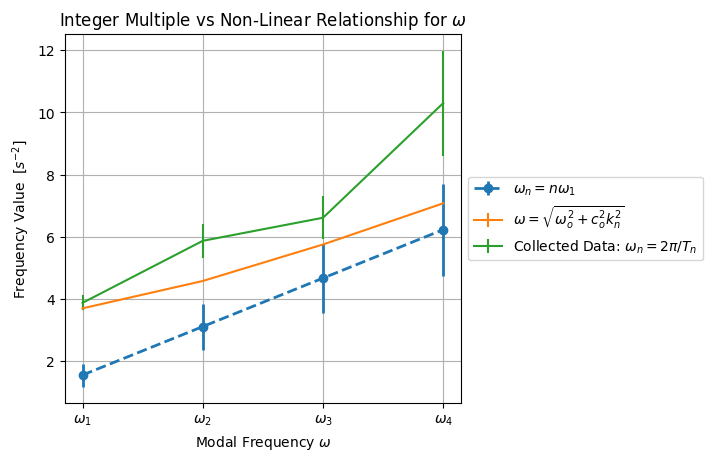

In [35]:
# Q4: Fundamental Frequency Integer Multiple Test
# setup-data
modes = range(1, 5)
K_n = [n*np.pi/LENGTH_SLINKY for n in modes]
W_n = [n*np.pi*C0/LENGTH_SLINKY for n in modes]
Ws = [equation_10(e) for e in W_n]

# collected data
periods_n = [16.2/10, 10.7/10, 9.5/10, 6.1/10]  # seconds
periods_n = convert_to_ufloat(periods_n, UNCERTAINTY_IPHONE)
frequency_n = [2*np.pi/e for e in periods_n]

# seperate
W_n_nominal, W_n_uncert = seperate_ufloat(W_n)
W_non_lin = [equation_10(W_n_nominal[i]) for i in range(len(W_n_nominal))]
W_non_lin_nominal, W_non_lin_uncert = seperate_ufloat(W_non_lin)
frequency_n_nominal, frequency_n_uncert = seperate_ufloat(frequency_n)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.errorbar(modes, W_n_nominal, yerr=W_n_uncert, fmt="o--", linewidth=2)
ax.errorbar(modes, W_non_lin_nominal, yerr=W_non_lin_uncert)
ax.errorbar(modes, frequency_n_nominal, yerr=frequency_n_uncert)

# plot settings
plt.xticks(modes, ["$\omega_{0:1d}$".format(n) for n in modes])
ax.set_title("Integer Multiple vs Non-Linear Relationship for $\omega$")
ax.set_xlabel("Modal Frequency $\omega$")
ax.set_ylabel("Frequency Value  $[s^{-2}]$")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(["$\omega_n = n\omega_1$", "$\omega = \sqrt{\omega_o^2 + c_{o}^2k_n^2}$", "Collected Data: $\omega_n = 2\pi/T_n$"], loc="center left", bbox_to_anchor=(1, 0.5))

#export_plot(fig, "q4_frequency_comparison")

# export the data (maybe?)

fig.show()

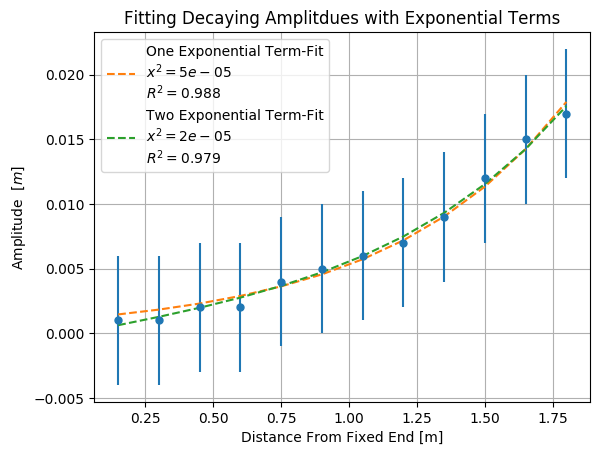

In [36]:
# Q5 part 1: Plot the decay of amplitude and fit it to one or two exponentials
# data
amplitudes = [1.7, 1.5, 1.2, 0.9, 0.7, 0.6, 0.5, 0.4, 0.2, 0.2, 0.1, 0.1]
amplitudes = [e/100 for e in amplitudes[::-1]]
positions = np.linspace(15/100, 180/100, 12).tolist()

# convert to ufloat
amplitudes = convert_to_ufloat(amplitudes, UNCERTAINTY_RULER)
positions = convert_to_ufloat(positions, UNCERTAINTY_RULER)

# seperate nominal and uncert
amplitudes_nominal, amplitudes_uncert = seperate_ufloat(amplitudes)
positions_nominal, positions_uncert = seperate_ufloat(positions)

# exponential functions for fitting
def one_exponential(x, k, y0):
    return y0 * np.exp(k * x)

def two_exponential(x, k, y0):
    return y0 * (np.exp(k * x) - np.exp(-k * x))

# fitting exponentials
fit1, covar1 = opt.curve_fit(one_exponential, positions_nominal, amplitudes_nominal)
fit2, covar2 = opt.curve_fit(two_exponential, positions_nominal, amplitudes_nominal)

# generate fit-data
amplitude_fit1, amplitude_fit2 = [], []
for i in range(len(amplitudes)):
    amplitude_fit1.append(one_exponential(positions_nominal[i], fit1[0], fit1[1]))
    amplitude_fit2.append(two_exponential(positions_nominal[i], fit2[0], fit2[1]))

# plot with 1 expotential fit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(positions_nominal, amplitudes_nominal,positions_uncert, amplitudes_uncert, "o", markersize=5)
ax.set_title("Fitting Decaying Amplitdues with Exponential Terms")
ax.set_ylabel("Amplitude  $[m]$")
ax.set_xlabel("Distance From Fixed End [m]")
ax.plot(positions_nominal, amplitude_fit1, "--")
ax.plot(positions_nominal, amplitude_fit2, "--")
ax.grid(True)

# generate x^2 and R^2
oneExpChiSquared = chiSquared(positions_nominal, amplitudes_nominal, lambda x: one_exponential(x, fit1[0], fit1[1]))
twoExpChiSquared = chiSquared(positions_nominal, amplitudes_nominal, lambda x: two_exponential(x, fit2[0], fit2[1]))

oneR2 = coeff_of_determination(positions_nominal, amplitudes_nominal, lambda x: one_exponential(x, fit1[0], fit1[1]))

twoR2 = coeff_of_determination(positions_nominal, amplitudes_nominal, lambda x: one_exponential(x, fit2[0], fit2[1]))


ax.legend(
    ["One Exponential Term-Fit\n$x^2={}$\n$R^2={}$".format(round_sig(oneExpChiSquared, 1), round_sig(oneR2, 3)), "Two Exponential Term-Fit\n$x^2={}$\n$R^2={}$".format(round_sig(twoExpChiSquared, 1) ,round_sig(twoR2, 3))]
    )

#export_plot(fig, "q5_1_one_vs_two_exponential_fit")
fig.show()

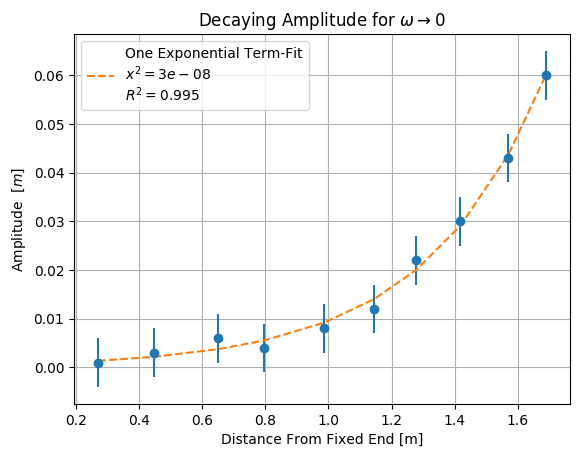

In [37]:
# Q5 part 2: w->0 amplitude analysis
# data
prePosition = [11, 23, 38.2, 52.2, 65.5, 81.3, 100.5, 115, 135.5, 153.1] # cm
prePosition = [abs(e/100-LENGTH_SLINKY.nominal_value) for e in prePosition[::-1]]
afterPosition = [5, 18.7, 35.2, 50, 64.3, 80.5, 100.1, 114.4, 135.2, 153] # cm
afterPosition = [abs(e/100-LENGTH_SLINKY.nominal_value) for e in afterPosition[::-1]]

# calculate amplitude
amplitudes = [abs(prePosition[i] - afterPosition[i]) for i in range(len(prePosition))]

# convert to ufloat
prePosition = convert_to_ufloat(prePosition, UNCERTAINTY_RULER)
amplitudes = convert_to_ufloat(amplitudes, UNCERTAINTY_RULER)

# seperate
prePosition_nominal, prePosition_uncert = seperate_ufloat(prePosition)
amplitudes_nominal, amplitudes_uncert = seperate_ufloat(amplitudes)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(prePosition_nominal, amplitudes_nominal, xerr=prePosition_uncert, yerr=amplitudes_uncert, fmt="o")
ax.set_title("Decaying Amplitude for $\omega\\rightarrow 0$")
ax.set_ylabel("Amplitude  $[m]$")
ax.set_xlabel("Distance From Fixed End [m]")

# fit one exponential
fit1, covar1 = opt.curve_fit(one_exponential, prePosition_nominal, amplitudes_nominal)

amplitude_fit1 = []
for i in range(len(amplitudes)):
    amplitude_fit1.append(one_exponential(prePosition_nominal[i], fit1[0], fit1[1]))

ax.plot(prePosition_nominal, amplitude_fit1, "--")
ax.grid(True)

# calculate x^2 and r^2
oneExpChiSquared = chiSquared(prePosition_nominal, amplitudes_nominal, lambda x: one_exponential(x, fit1[0], fit1[1]))
oneR2 = coeff_of_determination(prePosition_nominal, amplitudes_nominal, lambda x: one_exponential(x, fit1[0], fit1[1]))


# legend
ax.legend(
    ["One Exponential Term-Fit\n$x^2={}$\n$R^2={}$".format(round_sig(oneExpChiSquared, 1), round_sig(oneR2, 3))]
    )

# export
export_plot(fig, "q5_2_one_exponential_fit_wzero")

fig.show()

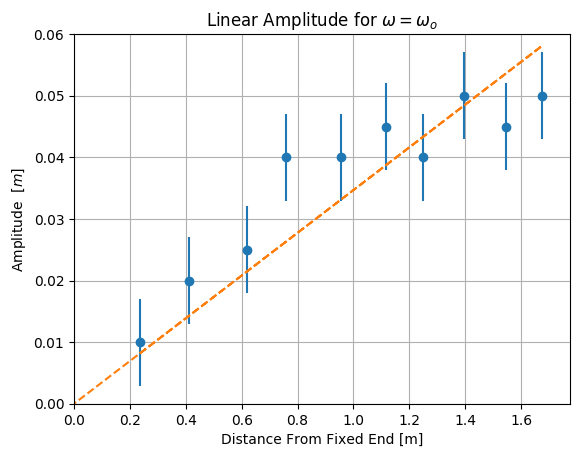

In [38]:
# Q6: Compare Amplitudes with Equation (18)

def equation_18_linear(yd, x):
    return yd * x/LENGTH_SLINKY

# collected data
positions = [(10, 15), (23, 27.5), (38, 43), (53, 57), (66, 70.5), (82.5, 86.5), (102, 106), (117, 119.5), (138, 140), (156, 157)]
amplitudes = [abs(abs(e[0] - 100*LENGTH_SLINKY.nominal_value) - abs(e[1] - 100*LENGTH_SLINKY.nominal_value))/100 for e in positions[::-1]]
avgPositions = [abs(abs(e[0] - 100*LENGTH_SLINKY.nominal_value) + abs(e[1] - 100*LENGTH_SLINKY.nominal_value))/(2*100) for e in positions[::-1]]

# convert to ufloat
# avgPositions.insert(0, 0)
# amplitudes.insert(0, 0)
amplitudes = convert_to_ufloat(amplitudes, umath.sqrt(2*umath.pow(UNCERTAINTY_RULER, 2)))
avgPositions = convert_to_ufloat(avgPositions, umath.sqrt(2*umath.pow(UNCERTAINTY_RULER, 2))/2)

# seperate
amplitudes_nominal, amplitudes_uncert = seperate_ufloat(amplitudes)
avgPositions_nominal, avgPositions_uncert = seperate_ufloat(avgPositions)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Linear Amplitude for $\omega =  \omega_o$")
ax.set_ylabel("Amplitude  $[m]$")
ax.set_xlabel("Distance From Fixed End [m]")
ax.errorbar(avgPositions_nominal, amplitudes_nominal, xerr=avgPositions_uncert, yerr=amplitudes_uncert,fmt="o")
ax.grid(True)

# linear fitting: fit the curve
z = np.polyfit(avgPositions_nominal, amplitudes_nominal, deg=1)
p = np.poly1d(z)

x = np.array(avgPositions_nominal + [0])

y = np.array(amplitudes_nominal + [0])

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

ax.plot(x, a*x, '--')

# set limits
xMin = min(avgPositions_nominal)
xMax = max(avgPositions_nominal)
yMin = min(amplitudes_nominal)
yMax = max(amplitudes_nominal)
epsilon = 0.1
h = 0.01

ax.set_xlim([0, xMax + epsilon])
ax.set_ylim([0, yMax + h])

# export data
export_plotting_data([], pre="##Q6##", newSet=True)
export_plotting_data(avgPositions_nominal, pre="average position: ")
export_plotting_data(amplitudes_nominal, pre="amplitude: ")

# save plot
export_plot(fig, "q6_linear_amplitude")


fig.show()

In [39]:
# Q7: Removal of Energy During Tunneling

# data
Hs = ufloat((70.5-48)/100, UNCERTAINTY_RULER)
W0s = umath.pow(G/Hs, 1/2)
amplitudes = [16.5 - 12, 33.5 - 29.5, 41.5 - 38, 0]
amplitudes = amplitudes[::-1]
avgPos = [(16.5+12)/200, (33.5 + 29.5)/200, (41.5+38)/200, (85+85)/200]
avgPos = [abs(e-LENGTH_SLINKY.nominal_value) for e in avgPos[::-1]]

# uncerts
amplitudes = convert_to_ufloat(amplitudes, umath.sqrt(2*umath.pow(UNCERTAINTY_RULER, 2)))
avgPos = convert_to_ufloat(avgPos, umath.sqrt(2*umath.pow(UNCERTAINTY_RULER, 2))/2)

# seperate
amplitudes_nominal, amplitudes_uncert = seperate_ufloat(amplitudes)
avgPos_nominal, avgPos_uncert = seperate_ufloat(avgPos)

# # generate Energy: propto A^2
# energies = amplitudes

# # plot E proportional to amplitude squared
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_title("Removal of Energy Due to the Tunnel")
# ax.set_ylabel("$\omega$")
# ax.set_xlabel("Distance From Fixed End [m]")
# # ax.errorbar(avgPositions_nominal, amplitudes_nominal, xerr=avgPositions_uncert, yerr=amplitudes_uncert,fmt="o")
# ax.grid(True)